In [1]:
import sys
# import comet_ml
import torch

import numpy as np

from sklearn.metrics import (
    f1_score, confusion_matrix, classification_report,
    balanced_accuracy_score, accuracy_score,
)
# from transformers.integrations import CometCallback

sys.path.append('..')
from lib.utils import set_seed, get_device
from lib.utils.constants import RANDOM_SEED
from lib.data.loading import pd_read_jsonl_file

In [2]:
import os
# from dotenv import load_dotenv

# load_dotenv()

# comet_api_key = os.getenv("COMET_API_KEY")

os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [3]:
import torch

torch.cuda.empty_cache()

In [4]:
set_seed(RANDOM_SEED)

DEVICE = get_device()
print(f'Using device: {DEVICE}')

Using device: cuda


In [5]:
df_en_train = pd_read_jsonl_file('../data/en_train.jsonl')
df_en_dev = pd_read_jsonl_file('../data/en_dev.jsonl')
df_en_test = pd_read_jsonl_file('../data/en_devtest_text_id_only.jsonl')

In [5]:
df_en_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 610767 entries, 0 to 610766
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          610767 non-null  object
 1   source      610767 non-null  object
 2   sub_source  610767 non-null  object
 3   lang        610767 non-null  object
 4   model       610767 non-null  object
 5   label       610767 non-null  int64 
 6   text        610767 non-null  object
dtypes: int64(1), object(6)
memory usage: 32.6+ MB


In [6]:
df_en_train.head()

,id,source,sub_source,lang,model,label,text
0,f05034ca-d1da-445d-a6a2-5869ade0dfc3,m4gt,reddit,en,llama3-8b,1,Hitler's plans for the succession and power st...
1,e7d7fe23-3709-4e14-aa2d-d76821dcbdf6,mage,squad,en,human,0,The Bush administration then turned its attent...
2,1a68d42e-4202-4e36-bceb-02d693440a14,mage,yelp,en,human,0,Really really the best pedi ever! Pho was so a...
3,5de844ab-c197-4378-b144-c3a46e3f5b67,mage,xsum,en,human,0,The PS42m MV Loch Seaforth made its first pass...
4,cdf050ad-7d90-4235-b7c6-46ca6cfc4382,m4gt,wikipedia,en,human,0,Malta participated in the Eurovision Song Cont...


In [6]:
MODEL_NAME = "Qwen/Qwen2.5-0.5B"

In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

In [8]:
# Count the number of tokens in each sentence
df_en_train['num_tokens'] = df_en_train['text'].apply(lambda x: len(tokenizer(x)['input_ids']))
df_en_dev['num_tokens'] = df_en_dev['text'].apply(lambda x: len(tokenizer(x)['input_ids']))
df_en_test['num_tokens'] = df_en_test['text'].apply(lambda x: len(tokenizer(x)['input_ids']))

In [9]:
df_en_train['num_tokens'].describe()

count    610767.000000
mean        314.066328
std         324.771124
min           1.000000
25%         110.000000
50%         237.000000
75%         407.000000
max        5797.000000
Name: num_tokens, dtype: float64

In [10]:
df_en_dev['num_tokens'].describe()

count    261758.000000
mean        314.357544
std         324.462363
min           1.000000
25%         111.000000
50%         237.000000
75%         407.000000
max        6207.000000
Name: num_tokens, dtype: float64

In [11]:
df_en_test['num_tokens'].describe()

count    32557.000000
mean       432.433394
std        359.554774
min          7.000000
25%        252.000000
50%        341.000000
75%        504.000000
max      17645.000000
Name: num_tokens, dtype: float64

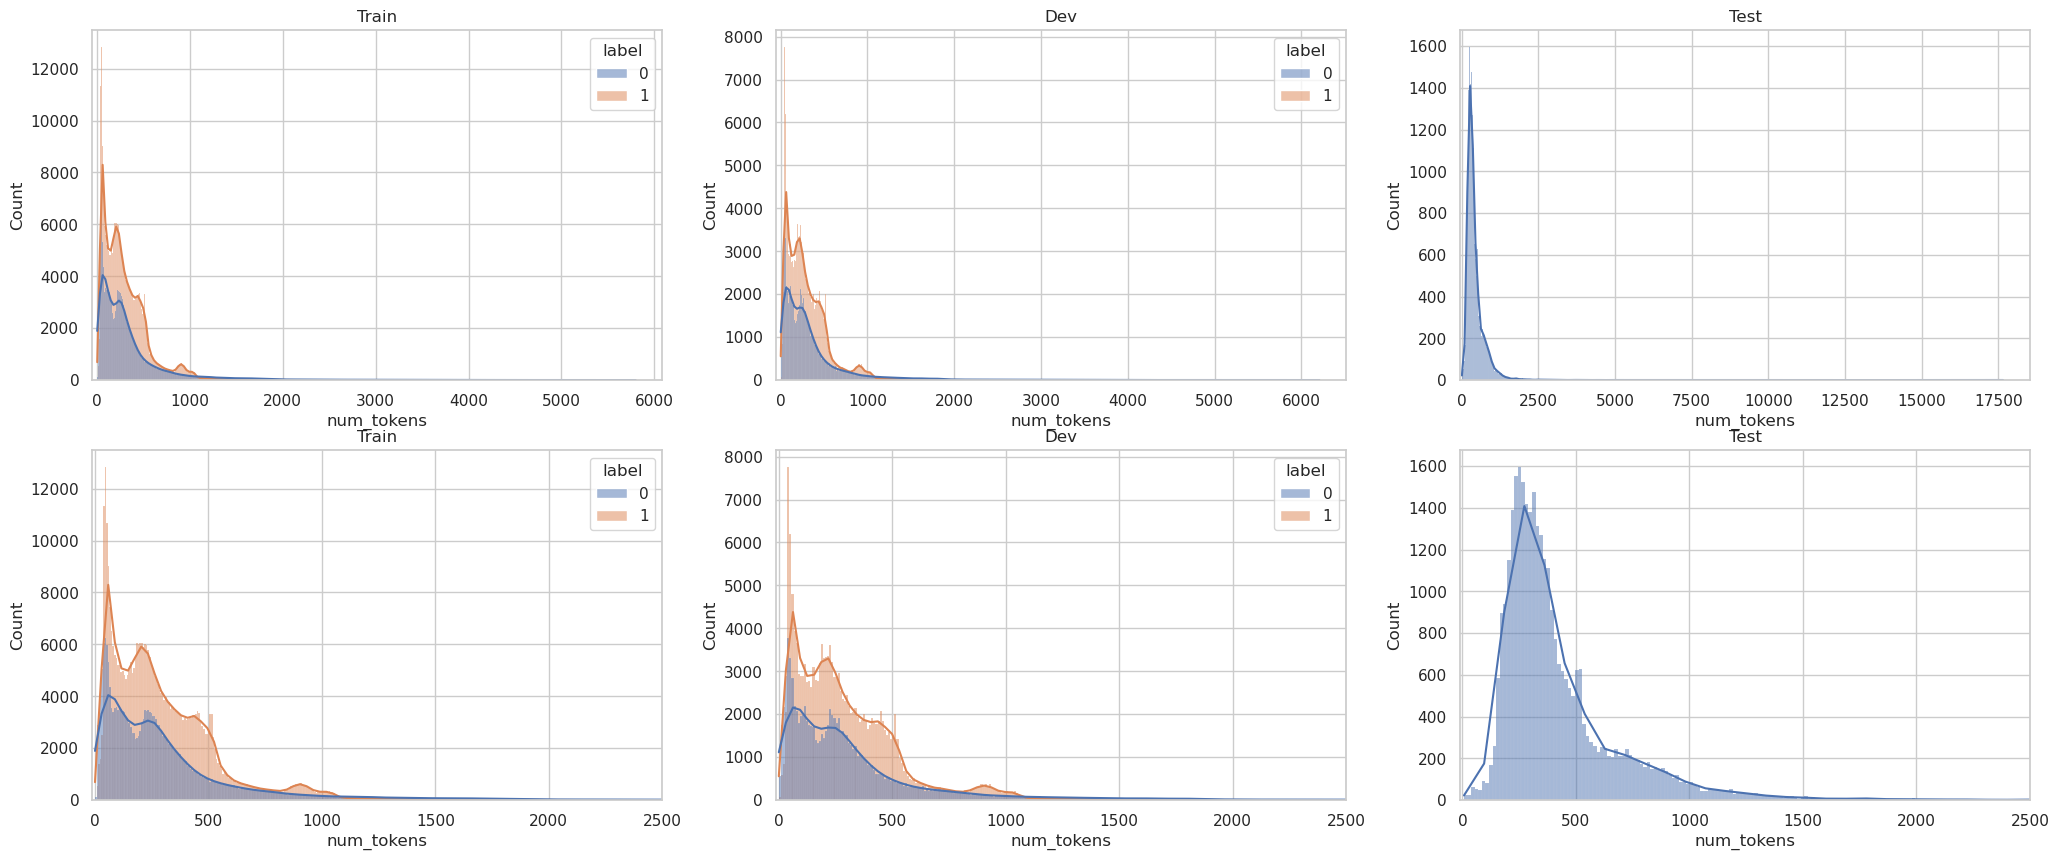

In [12]:
# Create a distribution plot over the number of tokens grouped by dataset and label
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

fig, ax = plt.subplots(2, 3, figsize=(25, 10))

sns.histplot(df_en_train, x='num_tokens', hue='label', kde=True, ax=ax[0][0])
sns.histplot(df_en_dev, x='num_tokens', hue='label', kde=True, ax=ax[0][1])
sns.histplot(df_en_test, x='num_tokens', kde=True, ax=ax[0][2])

sns.histplot(df_en_train, x='num_tokens', hue='label', kde=True, ax=ax[1][0])
sns.histplot(df_en_dev, x='num_tokens', hue='label', kde=True, ax=ax[1][1])
sns.histplot(df_en_test, x='num_tokens', kde=True, ax=ax[1][2])

ax[0][0].set_title('Train')
ax[0][0].set_xlim(left=-50)
ax[0][1].set_title('Dev')
ax[0][1].set_xlim(left=-50)
ax[0][2].set_title('Test')
ax[0][2].set_xlim(left=-50)

ax[1][0].set_title('Train')
ax[1][0].set_xlim(left=-10, right=2500)
ax[1][1].set_title('Dev')
ax[1][1].set_xlim(left=-10, right=2500)
ax[1][2].set_title('Test')
ax[1][2].set_xlim(left=-10, right=2500)

plt.show()

# Load model

In [6]:
MODEL_NAME = "Qwen/Qwen2.5-0.5B"

In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

Some weights of Qwen2ForSequenceClassification were not initialized from the model checkpoint at Qwen/Qwen2.5-0.5B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# If a pad_token_id is defined in the configuration,
# it finds the last token that is not a padding token in each row.
# If no pad_token_id is defined, it simply takes the last value in each row of the batch.
model.config.pad_token_id = tokenizer.pad_token_id

In [9]:
model.config.pad_token_id

151643

In [11]:
model

Qwen2ForSequenceClassification(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): 

In [13]:
for param in model.parameters():
    param.requires_grad = False

for param in model.model.layers[-1].parameters():
    param.requires_grad = True

for param in model.score.parameters():
    param.requires_grad = True

In [14]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

model.layers.23.self_attn.q_proj.weight
model.layers.23.self_attn.q_proj.bias
model.layers.23.self_attn.k_proj.weight
model.layers.23.self_attn.k_proj.bias
model.layers.23.self_attn.v_proj.weight
model.layers.23.self_attn.v_proj.bias
model.layers.23.self_attn.o_proj.weight
model.layers.23.mlp.gate_proj.weight
model.layers.23.mlp.up_proj.weight
model.layers.23.mlp.down_proj.weight
model.layers.23.input_layernorm.weight
model.layers.23.post_attention_layernorm.weight
score.weight


In [15]:
def get_num_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


trainable_params = get_num_parameters(model)
print(f'Trainable parameters: {trainable_params} ({trainable_params / model.num_parameters():.2%})')

Trainable parameters: 14914176 (3.02%)


# Measure performance before training/fine-tuning the model

In [ ]:
import torch

from tqdm import tqdm


def get_performance_metrics(y_true, y_pred):
    f1 = f1_score(y_true, y_pred, average='macro')
    acc = accuracy_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred)

    return {
        'f1': f1,
        'accuracy': acc,
        'balanced_accuracy': bal_acc,
        'confusion_matrix': cm,
        'classification_report': cr
    }


def measure_initial_performance(model, tokenizer, df_test, device, max_length=512, batch_size=64):
    model.to(device)
    model.eval()

    test_samples = df_test.text.tolist()

    outputs = []
    for i in tqdm(range(0, len(test_samples), batch_size)):
        batch = test_samples[i:i + batch_size]
        inputs = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            output = model(**inputs)
            outputs.append(output.logits)

    outputs = torch.cat(outputs, dim=0)
    predictions = torch.argmax(outputs, dim=1).cpu().numpy()

    performance = get_performance_metrics(df_test.label, predictions)
    return performance


initial_performance = measure_initial_performance(model, tokenizer, df_en_dev, DEVICE)
initial_performance

In [11]:
def test_samples(model, tokenizer, df, device, max_length=512):
    model.to(device)
    model.eval()

    test_samples = df.text.tolist()[:5]
    inputs = tokenizer(
        test_samples,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs).logits

    # print(outputs.shape)
    print(outputs)

In [12]:
test_samples(model, tokenizer, df_en_train, DEVICE)

tensor([[-0.0314,  0.0181],
        [-0.0319,  0.0190],
        [-0.0338,  0.0227],
        [-0.0318,  0.0197],
        [-0.0323,  0.0195]], device='cuda:0')


# Fine-tune the model

In [16]:
class_weights = (
    1 / df_en_train.label.value_counts(normalize=True).sort_index()
).tolist()
class_weights = torch.tensor(class_weights)
class_weights = class_weights / class_weights.sum()

class_weights

tensor([0.6252, 0.3748])

In [17]:
from datasets import Dataset, DatasetDict

ds_train = Dataset.from_pandas(df_en_train)
ds_dev = Dataset.from_pandas(df_en_dev)
ds_test = Dataset.from_pandas(df_en_test)

/root/.conda/envs/pytorch/lib/python3.11/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


In [18]:
ds_train

Dataset({
    features: ['id', 'source', 'sub_source', 'lang', 'model', 'label', 'text'],
    num_rows: 610767
})

In [19]:
ds_train_shuffled = ds_train.shuffle(seed=RANDOM_SEED)

In [20]:
dataset = DatasetDict({
    'train': ds_train_shuffled,
    'dev': ds_dev,
    'test': ds_test
})

In [21]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'source', 'sub_source', 'lang', 'model', 'label', 'text'],
        num_rows: 610767
    })
    dev: Dataset({
        features: ['id', 'source', 'sub_source', 'lang', 'model', 'label', 'text'],
        num_rows: 261758
    })
    test: Dataset({
        features: ['id', 'text'],
        num_rows: 32557
    })
})

In [22]:
MAX_LEN = 2048
# col_to_delete = ['source', 'sub_source', 'lang', 'model']


def preprocess_dataset(ds):
    return tokenizer(ds['text'], truncation=True, max_length=MAX_LEN)


tokenized_datasets = dataset.map(preprocess_dataset, batched=True)
tokenized_datasets.set_format("torch")
     

Map:   0%|          | 0/610767 [00:00<?, ? examples/s]

Map:   0%|          | 0/261758 [00:00<?, ? examples/s]

Map:   0%|          | 0/32557 [00:00<?, ? examples/s]

In [23]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'source', 'sub_source', 'lang', 'model', 'label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 610767
    })
    dev: Dataset({
        features: ['id', 'source', 'sub_source', 'lang', 'model', 'label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 261758
    })
    test: Dataset({
        features: ['id', 'text', 'input_ids', 'attention_mask'],
        num_rows: 32557
    })
})

In [24]:
from transformers import DataCollatorWithPadding

collate_fn = DataCollatorWithPadding(tokenizer=tokenizer)

In [25]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    return {
        'macro_f1': f1_score(predictions, labels, average='macro'),
        'accuracy': accuracy_score(predictions,labels),
        'balanced_accuracy': balanced_accuracy_score(predictions, labels),
    }

In [26]:
import torch
import torch.nn.functional as F

from transformers import Trainer


class WeightedCrossEntropyTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        if class_weights is not None:
            self.class_weights = torch.tensor(
                class_weights, dtype=torch.float32
        ).to(self.args.device)
        else:
            self.class_weights = None

    def compute_loss(self, model, inputs, return_outputs=False):
        # Extract labels and convert them to long type for cross_entropy
        labels = inputs.pop("labels").long()

        # Forward pass
        outputs = model(**inputs)

        # Extract logits assuming they are directly outputted by the model
        logits = outputs.get('logits')

        # Compute custom loss with class weights for imbalanced data handling
        if self.class_weights is not None:
            loss = F.cross_entropy(logits, labels, weight=self.class_weights)
        else:
            loss = F.cross_entropy(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [31]:
# from comet_ml import Experiment
# from comet_ml.integration.pytorch import log_model

# experiment = Experiment(
#     api_key=comet_api_key,
#     project_name="mgt-detection-coling-2025",
#     workspace="unibuc-phd",
# )

In [28]:
params = {
    "learning_rate": 2e-4,
    "num_train_epochs": 1,
    "weight_decay": 1e-2,
    "seed": RANDOM_SEED,
}

# experiment.log_parameters(params)

In [29]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='../results/subtask_a/001_qwen2.5-0.5B',
    learning_rate=params["learning_rate"],
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=params["num_train_epochs"],
    weight_decay=params["weight_decay"],
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    # report_to="comet_ml",
    seed=params["seed"],
)

comet_ml version 3.39.0 is installed, but version 3.43.2 or higher is required. Please update comet_ml to the latest version to enable Comet logging with pip install 'comet-ml>=3.43.2'.


In [30]:
trainer = WeightedCrossEntropyTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['dev'],
    tokenizer=tokenizer,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    class_weights=class_weights,
    # callbacks=[CometCallback()],
)

/tmp/ipykernel_15045/3314886341.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.class_weights = torch.tensor(


In [ ]:
train_result = trainer.train()

[2024-09-28 16:41:37,843] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: teodormarchitan (unibuc-nlp). Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss


In [ ]:
metrics = train_result.metrics
max_train_samples = len(ds_train)
metrics["train_samples"] = min(max_train_samples, len(ds_train))
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()

In [ ]:
trainer.save_model("../results/subtask_a/001_qwen2.5-0.5B/qwen2.5-0.5B")

In [39]:
import pandas as pd
from tqdm import tqdm


def make_predictions(model, tokenizer, df, device, file_path, max_len=MAX_LEN, batch_size=32):
    model.eval()

    all_ids = []
    all_predictions = []
    with torch.no_grad():
        for i in tqdm(range(0, len(df), batch_size)):
            ids = df[i:i + batch_size].id.tolist()
            texts = df[i:i + batch_size].text.tolist()

            inputs = tokenizer(texts, truncation=True, padding=True, max_length=max_len, return_tensors="pt")
            
            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)

            outputs = model(input_ids, attention_mask).logits
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            all_ids.extend(ids)
            all_predictions.extend(preds)

    df_predictions = pd.DataFrame({
        "id": all_ids,
        "label": all_predictions,
    })

    df_predictions.to_json(
        file_path,
        orient="records",
        lines=True,
    )

    return df_predictions
    

In [41]:
df_test_predictions = make_predictions(
    trainer.model,
    tokenizer,
    df_en_test,
    DEVICE,
    "../results/subtask_a/001_qwen2.5-0.5B/subtask_a.jsonl",
)

100%|██████████| 1018/1018 [24:23<00:00,  1.44s/it]


In [40]:
df_en_train.label.value_counts(normalize=True)

label
1    0.625189
0    0.374811
Name: proportion, dtype: float64

In [42]:
df_test_predictions.label.value_counts(normalize=True)

label
1    0.654452
0    0.345548
Name: proportion, dtype: float64

In [38]:
# experiment.end()